gofasta vs amanual mutation calling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO

In [2]:
pd.set_option('display.max_rows', 200)

In [3]:
hu1_gf_dir = '/home/eleanor124/projects/bjorn_rep/output/Hu1/gf_Hu1/'
hu1_mm_dir = '/home/eleanor124/projects/bjorn_rep/output/Hu1/mm/'
ba1_gf_dir = '/home/eleanor124/projects/bjorn_rep/output/Hu1/gf_BA1/'
ba2_gf_dir = '/home/eleanor124/projects/bjorn_rep/output/Hu1/gf_BA2/'


pb2_old_dir = '/home/eleanor124/projects/bjorn_rep/data/PB2-DMS/'
pb2_gf_dir = '/home/eleanor124/projects/bjorn_rep/output/PB2/gf_PP/'
pb2_mm_dir = '/home/eleanor124/projects/bjorn_rep/output/PB2/mm/'

cy_gf_dir = '/home/eleanor124/projects/bjorn_rep/output/PB2/gf_CY/'
cy_mm_dir = '/home/eleanor124/projects/bjorn_rep/output/PB2/mm/'


In [4]:
ambiguous_nuc = ['R', 'Y', 'W', 'S', 'K', 'M', 'B', 'D', 'H', 'V', 'N']

In [5]:
def process(path, common_set):
    df = pd.read_csv(path, sep="\t")
    if common_set:
        df_filtered = df.copy()
        df_filtered = df_filtered.loc[df_filtered["sra"].isin(common_set), :]

        return df, df_filtered
    else:
        return df, None


In [6]:
def corr_plt(standard, manual, title):

    standard_grp = (
        standard[~standard["alt"].str.upper().isin(ambiguous_nuc)]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_standard")
    )

    manual_grp = (
        manual[~manual["alt"].str.upper().isin(ambiguous_nuc)]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_manual")
    )
    
    merged2 = pd.merge(standard_grp, manual_grp, on='sra', how="outer").fillna(0)

    plt.scatter(merged2['pos_count_manual'], merged2['pos_count_standard'], color='lightblue')
    minv = min(merged2['pos_count_manual'])
    maxv = max(merged2['pos_count_manual'])
    
    plt.plot([minv, maxv], [minv, maxv], 'r--', label='y = x')
    plt.legend(loc='upper right')
    plt.xlabel("pos count - our mutation calling")
    plt.ylabel("pos count - standard")
    plt.title(f"Number of mutations in each position, excluding ambiguous nuc for ALT - {title}")
    plt.tight_layout()
    plt.show()

    return merged2[merged2['pos_count_standard'] != merged2['pos_count_manual']]


In [7]:
def get_common_seqs(fa1, fa2):
    seq1 = {rec.id: str(rec.seq).upper() for rec in SeqIO.parse(fa1, "fasta")}
    seq2 = {rec.id: str(rec.seq).upper() for rec in SeqIO.parse(fa2, "fasta")}
    common_ids = set(seq1.keys()) & set(seq2.keys())
    
    return [i for i in common_ids if seq1[i] == seq2[i]]

## Hu1-BA

100.0 % sequences in the alignment files are identical.


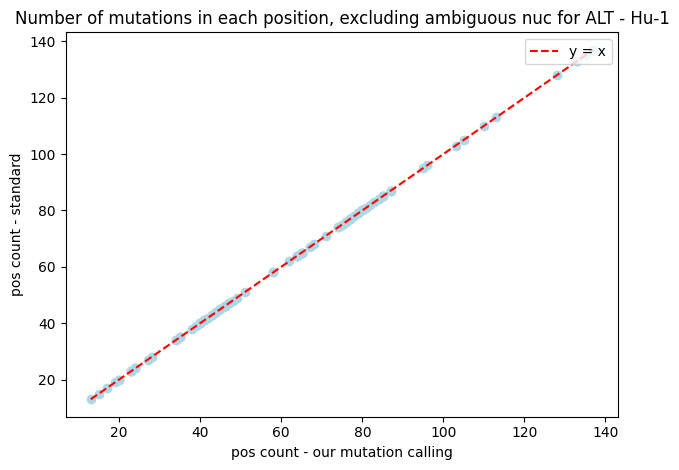

,sra,pos_count_standard,pos_count_manual,gap


In [20]:
common_set = get_common_seqs(hu1_gf_dir+"alignment.fasta", hu1_mm_dir+"alignment.fasta")

hu1_gf, hu1_gf_filtered = process(hu1_gf_dir+"mutations.tsv", common_set)
hu1_mm, hu1_mm_filtered = process(hu1_mm_dir+"mutations.tsv", common_set)

print(round(len(hu1_mm_filtered)/len(hu1_mm), 2)*100, "% sequences in the alignment files are identical.")

pos_mismatch = corr_plt(hu1_gf_filtered, hu1_mm_filtered, "Hu-1")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch.sort_values(by=["gap"], ascending=False)

In [28]:
tmp1 = (hu1_gf[~hu1_gf["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos"])
        .reset_index(drop=True)
)
tmp2 = (hu1_mm[~hu1_mm["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos"])
        .reset_index(drop=True)
)
tmp1.compare(tmp2, keep_equal=True)


GFF_FEATURE                 ref_aa       alt_aa        pos_aa        
                self           other   self other   self other    self   other
5     YP_009724389.1  YP_009724389.1      P     P      L     L  4715.0   314.0
7     YP_009724389.1  YP_009724389.1      P     P      S     S  6252.0  1851.0
39    YP_009724389.1  YP_009724389.1      P     P      L     L  4715.0   314.0
41    YP_009724389.1  YP_009724389.1      K     K      R     R  6711.0  2310.0
81    YP_009724389.1  YP_009724389.1      P     P      L     L  4715.0   314.0
...              ...             ...    ...   ...    ...   ...     ...     ...
6764  YP_009724389.1  YP_009724389.1      G     G      S     S  5063.0   662.0
6766  YP_009724389.1  YP_009724389.1      P     P      L     L  5401.0  1000.0
6767  YP_009724389.1  YP_009724389.1      I     I      V     V  5658.0  1257.0
6768  YP_009724389.1  YP_009724389.1      A     A      V     V  6319.0  1918.0
6786  YP_009724396.1  YP_009724396.1    NaN     Q    NaN     *     NaN    72.0

[679 rows x 8 columns]

96.0 % sequences in the alignment files are identical.


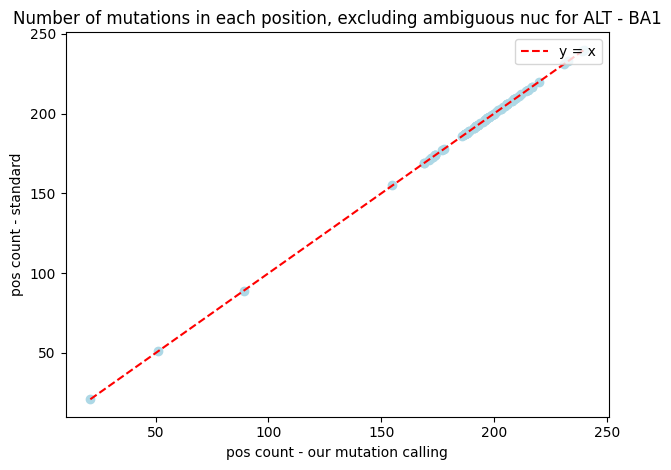

,sra,pos_count_standard,pos_count_manual,gap


In [29]:
common_set = get_common_seqs(ba1_gf_dir+"alignment.fasta", hu1_mm_dir+"alignment.fasta")

ba1_gf, ba1_gf_filtered = process(ba1_gf_dir+"mutations.tsv", common_set)
ba1_mm, ba1_mm_filtered = process(hu1_mm_dir+"NC_045512.2_BA.1_mutations.tsv", common_set)


print(round(len(ba1_mm_filtered)/len(ba1_mm), 2)*100, "% sequences in the alignment files are identical.")

pos_mismatch = corr_plt(ba1_gf_filtered, ba1_mm_filtered, "BA1")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch.sort_values(by=["gap"], ascending=False)

In [31]:
tmp1 = (ba1_gf_filtered[~ba1_gf_filtered["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos"])
        .reset_index(drop=True)
)
tmp2 = (ba1_mm_filtered[~ba1_mm_filtered["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos"])
        .reset_index(drop=True)
)

tmp1.compare(tmp2, keep_equal=True)

GFF_FEATURE                 ref_aa       alt_aa        pos_aa  \
                 self           other   self other   self other    self   
3      YP_009725295.1  YP_009724389.1      L     L      F     F  3606.0   
4      YP_009724389.1  YP_009725295.1      L     L      F     F  3606.0   
5      YP_009724389.1  YP_009724389.1      P     P      L     L  4715.0   
7      YP_009724389.1  YP_009724389.1      P     P      S     S  6252.0   
193    YP_009724389.1  YP_009724389.1      P     P      L     L  4715.0   
...               ...             ...    ...   ...    ...   ...     ...   
16555  YP_009724389.1  YP_009724389.1      G     G      S     S  5063.0   
16557  YP_009724389.1  YP_009724389.1      P     P      L     L  5401.0   
16558  YP_009724389.1  YP_009724389.1      I     I      V     V  5658.0   
16559  YP_009724389.1  YP_009724389.1      A     A      V     V  6319.0   
16729  YP_009724396.1  YP_009724396.1    NaN     Q    NaN     *     NaN   

               
        other  
3      3606.0  
4      3606.0  
5       314.0  
7      1851.0  
193     314.0  
...       ...  
16555   662.0  
16557  1000.0  
16558  1257.0  
16559  1918.0  
16729    72.0  

[527 rows x 8 columns]

100.0 % sequences in the alignment files are identical.


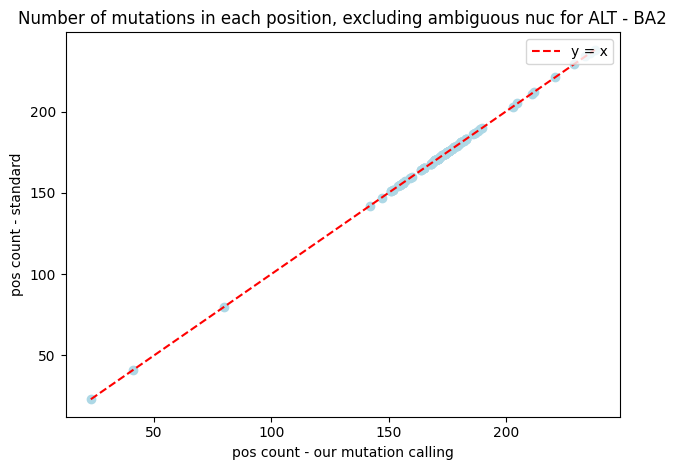

,sra,pos_count_standard,pos_count_manual,gap


In [34]:
common_set = get_common_seqs(ba2_gf_dir+"alignment.fasta", hu1_mm_dir+"alignment.fasta")

ba2_gf, ba2_gf_filtered = process(ba2_gf_dir+"mutations.tsv", common_set)
ba2_mm, ba2_mm_filtered = process(hu1_mm_dir+"NC_045512.2_BA.2_mutations.tsv", common_set)

print(round(len(ba2_mm_filtered)/len(ba2_mm), 2)*100, "% sequences in the alignment files are identical.")

pos_mismatch = corr_plt(ba2_gf_filtered, ba2_mm_filtered, "BA2")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch.sort_values(by=["gap"], ascending=False)


In [35]:
tmp1 = (ba2_gf[~ba2_gf["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos"])
        .reset_index(drop=True)
)
tmp2 = (ba2_mm[~ba2_mm["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos"])
        .reset_index(drop=True)
)

tmp1.compare(tmp2, keep_equal=True)

GFF_FEATURE                 ref_aa       alt_aa        pos_aa  \
                 self           other   self other   self other    self   
5      YP_009724389.1  YP_009724389.1      P     P      L     L  4715.0   
7      YP_009724389.1  YP_009724389.1      P     P      S     S  6252.0   
150    YP_009725295.1  YP_009724389.1      P     P      L     L   309.0   
151    YP_009724389.1  YP_009725295.1      P     P      L     L   309.0   
153    YP_009725295.1  YP_009724389.1      S     S      P     P   528.0   
...               ...             ...    ...   ...    ...   ...     ...   
17564  YP_009724389.1  YP_009724389.1      G     G      S     S  5063.0   
17566  YP_009724389.1  YP_009724389.1      P     P      L     L  5401.0   
17567  YP_009724389.1  YP_009724389.1      I     I      V     V  5658.0   
17568  YP_009724389.1  YP_009724389.1      A     A      V     V  6319.0   
17716  YP_009724396.1  YP_009724396.1    NaN     Q    NaN     *     NaN   

               
        other  
5       314.0  
7      1851.0  
150     309.0  
151     309.0  
153     528.0  
...       ...  
17564   662.0  
17566  1000.0  
17567  1257.0  
17568  1918.0  
17716    72.0  

[1468 rows x 8 columns]

## PB2 - DMS

100.0 % sequences in the alignment files are identical.


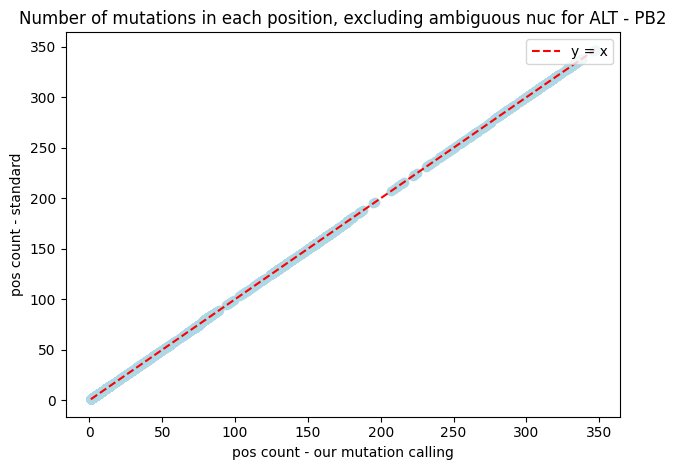

,sra,pos_count_standard,pos_count_manual,gap


In [36]:
common_set = get_common_seqs(pb2_gf_dir+"alignment.fasta", pb2_mm_dir+"alignment.fasta")

pb2_gf, pb2_gf_filtered = process(pb2_gf_dir+"mutations.tsv", common_set)
pb2_mm, pb2_mm_filtered = process(pb2_mm_dir+"mutations.tsv", common_set)

print(round(len(pb2_mm_filtered)/len(pb2_mm), 2)*100, "% sequences in the alignment files are identical.")

pos_mismatch = corr_plt(pb2_gf_filtered, pb2_mm_filtered, "PB2")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch.sort_values(by=["gap"], ascending=False)


In [37]:
tmp1 = (pb2_gf[~pb2_gf["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos"])
        .reset_index(drop=True)
)
tmp2 = (pb2_mm[~pb2_mm["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos"])
        .reset_index(drop=True)
)

tmp1.compare(tmp2, keep_equal=True)

GFF_FEATURE             ref_aa       alt_aa       pos_aa       
              self       other   self other   self other   self  other
2068           NaN  XAJ25426.1    NaN     D    NaN     B    NaN  195.0
23702          NaN  XAJ25426.1    NaN     K    NaN     X    NaN  121.0
25471          NaN  XAJ25426.1    NaN     I    NaN     X    NaN  109.0
36865          NaN  XAJ25426.1    NaN     L    NaN     X    NaN  207.0
37510          NaN  XAJ25426.1    NaN     N    NaN     X    NaN  456.0
...            ...         ...    ...   ...    ...   ...    ...    ...
725189         NaN  XAJ25426.1    NaN     I    NaN     X    NaN  495.0
725337         NaN  XAJ25426.1    NaN     A    NaN     X    NaN  676.0
725910         NaN  XAJ25426.1    NaN     T    NaN     X    NaN  471.0
726004         NaN  XAJ25426.1    NaN     R    NaN     X    NaN  299.0
726053         NaN  XAJ25426.1    NaN     R    NaN     X    NaN  299.0

[272 rows x 8 columns]

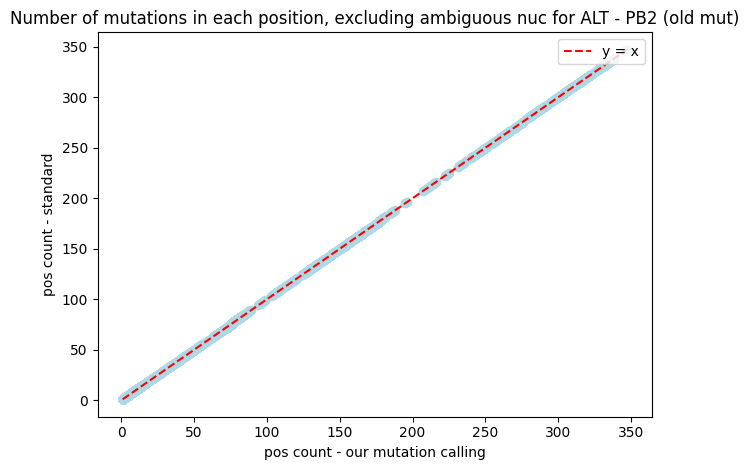

,sra,pos_count_standard,pos_count_manual,gap
324,SRR24839382,332,331,-1
955,SRR24843066,267,266,-1


In [38]:
pb2_old, _ = process(pb2_old_dir+"mutations.tsv", None)
pb2_mm, _ = process(pb2_mm_dir+"mutations.tsv", None)
pb2_mm["sra"] = pb2_mm["sra"].apply(lambda x: x.split('_')[1])

pos_mismatch = corr_plt(pb2_old, pb2_mm, "PB2 (old mut)")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch.sort_values(by=["gap"], ascending=False)


In [39]:
tmp1 = (pb2_old[(~pb2_old["alt"].isin(ambiguous_nuc)) & (~pb2_old["alt"].str.startswith("+"))] # ins from gofasta sam variants??
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos"])
        .reset_index(drop=True)
)
tmp2 = (pb2_mm[~pb2_mm["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos"])
        .reset_index(drop=True)
)

tmp1.compare(tmp2, keep_equal=True)

GFF_FEATURE             ref_aa       alt_aa       pos_aa       
              self       other   self other   self other   self  other
2068           NaN  XAJ25426.1    NaN     D    NaN     B    NaN  195.0
23702          NaN  XAJ25426.1    NaN     K    NaN     X    NaN  121.0
25471          NaN  XAJ25426.1    NaN     I    NaN     X    NaN  109.0
36865          NaN  XAJ25426.1    NaN     L    NaN     X    NaN  207.0
37510          NaN  XAJ25426.1    NaN     N    NaN     X    NaN  456.0
...            ...         ...    ...   ...    ...   ...    ...    ...
725189         NaN  XAJ25426.1    NaN     I    NaN     X    NaN  495.0
725337         NaN  XAJ25426.1    NaN     A    NaN     X    NaN  676.0
725910         NaN  XAJ25426.1    NaN     T    NaN     X    NaN  471.0
726004         NaN  XAJ25426.1    NaN     R    NaN     X    NaN  299.0
726053         NaN  XAJ25426.1    NaN     R    NaN     X    NaN  299.0

[272 rows x 8 columns]

In [ ]:
common_set = get_common_seqs(cy_gf_dir+"alignment.fasta", cy_mm_dir+"alignment.fasta")

cy_mm, cy_mm_filtered = process(cy_mm_dir+"CY018884.1_cds_ABM21959.1_1_mutations.tsv", common_set)
cy_mm_filtered["sra"] = cy_mm_filtered["sra"].apply(lambda x: x.split('_')[1])
cy_gf, cy_gf_filtered = process(cy_gf_dir+"mutations.tsv", common_set)
cy_gf_filtered["sra"] = cy_gf_filtered["sra"].apply(lambda x: x.split('_')[1])

print(round(len(cy_mm_filtered)/len(cy_mm), 2)*100, "% sequences are identical.")

pos_mismatch = corr_plt(cy_gf_filtered, cy_mm_filtered, "CY")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch = pos_mismatch.sort_values(by=["gap"], ascending=False)

pos_mismatch

In [ ]:
tmp1 = (cy_gf_filtered[~cy_gf_filtered["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos"])
        .reset_index(drop=True)
)
tmp2 = (cy_mm_filtered[~cy_mm_filtered["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos"])
        .reset_index(drop=True)
)

tmp1.compare(tmp2, keep_equal=True)

In [ ]:
for i in range(len(unmapped_ls)):
    f = list(SeqIO.parse("/home/eleanor124/projects/bjorn_rep/data/PB2-DMS/PB2_samples/"+unmapped_ls[i], "fasta"))
    count = f[0].seq.count('-')+f[0].seq.count('N')
    print(count/len(f[0].seq)*100)

In [ ]:
f = list(SeqIO.parse("/home/eleanor124/projects/bjorn_rep/data/PB2-DMS/PB2_samples/SRR33319052_PB2_cns.fa", "fasta"))
count = f[0].seq.count('-')+f[0].seq.count('N')
print(count/len(f[0].seq)*100)

In [ ]:
tmp1 = cy_gf.loc[(cy_gf["sra"] == "SRR33319052") & (~cy_gf["alt"].isin(ambiguous_nuc)), :]
tmp2 = cy_mm.loc[(cy_mm["sra"] == "SRR33319052") & (~cy_mm["alt"].isin(ambiguous_nuc)), :]
m = pd.merge(tmp1, tmp2, how="outer", indicator=True, on=["sra", "pos"])
m[m["_merge"]!="both"]

In [ ]:
combined_fasta = list(SeqIO.parse('/home/eleanor124/projects/bjorn_rep/output/Hu1/gf_BA2/combined.fasta', "fasta"))
combined_fasta_ls = [rec.id for rec in combined_fasta]

alignment_fasta = list(SeqIO.parse('/home/eleanor124/projects/bjorn_rep/output/Hu1/gf_BA2/alignment.fasta', "fasta"))
alignment_fasta_ls = [rec.id for rec in alignment_fasta]

list(set(combined_fasta_ls) - set(alignment_fasta_ls))

In [ ]:
# combined_fasta = list(SeqIO.parse('/home/eleanor124/projects/bjorn_rep/output/Hu1/gf_BA2/combined.fasta', "fasta"))
# combined_fasta_ls = [rec.id for rec in combined_fasta]

# list(set(combined_fasta_ls) - set(alignment_fasta_ls))

alignment_fasta = list(SeqIO.parse('/home/eleanor124/projects/bjorn_rep/output/Hu1/gf_BA1/alignment.fasta', "fasta"))
alignment_id = [rec.id for rec in alignment_fasta]
alignment_seq = [rec.seq for rec in alignment_fasta]
df_ba1 = pd.DataFrame({'id': alignment_id, 'seq': alignment_seq})

alignment_fasta = list(SeqIO.parse('/home/eleanor124/projects/bjorn_rep/output/Hu1/mm/alignment.fasta', "fasta"))
alignment_id = [rec.id for rec in alignment_fasta]
alignment_seq = [rec.seq for rec in alignment_fasta]
df_hu1 = pd.DataFrame({'id': alignment_id, 'seq': alignment_seq})

m = pd.merge(df_hu1, df_ba1, on=['id', 'seq'], how='inner')

In [ ]:
dic_ba1 = {rec.id: str(rec.seq).upper() for rec in SeqIO.parse('/home/eleanor124/projects/bjorn_rep/output/Hu1/gf_BA1/alignment.fasta', "fasta")}
dic_hu1 = {rec.id: str(rec.seq).upper() for rec in SeqIO.parse('/home/eleanor124/projects/bjorn_rep/output/Hu1/mm/alignment.fasta', "fasta")}

In [ ]:
dic_ba1["hCoV-19/USA/STM-0007112-C10/2021"] == dic_hu1["hCoV-19/USA/STM-0007112-C10/2021"]

In [ ]:
'hCoV-19/USA/STM-0007112-C10/2021' in m["id"]

In [ ]:
combined_fasta = list(SeqIO.parse('/home/eleanor124/projects/bjorn_rep/output/Hu1/gf_BA2/combined.fasta', "fasta"))
combined_fasta_ls = [rec.id for rec in combined_fasta]

alignment_fasta = list(SeqIO.parse('/home/eleanor124/projects/bjorn_rep/output/Hu1/mm/alignment.fasta', "fasta"))
alignment_fasta_ls = [rec.id for rec in alignment_fasta]

list(set(combined_fasta_ls) - set(alignment_fasta_ls))